In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QEC 101 Lab 1 - The Basics of Classical and Quantum Error Correction

$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$
---
## Overview
One of the biggest challenges in realizing practical quantum computing is the noisy nature of qubits, making quantum error correction (QEC) essential for detecting and fixing errors in real time. In this lab, you’ll explore the fundamentals of error correction (EC) concepts and terminology, walk through examples of classical EC codes, examine how QEC differs from classical methods, and ultimately get hands-on experience coding your first QEC procedure.

**Prerequisites:**
Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q.  It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, and circuit sampling. The  CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provide a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing.

The list below outlines what you'll be doing in each section of this lab:

* **1.1** Define the basics of EC, including the 5 aspects common to EC procedures
* **1.2** Code the classical repetition code
* **1.3** Code the classical Hamming code
* **1.4** Experiment with noisy qubits to understand what makes QEC challenging
* **1.5** Explore why there is still hope for QEC
* **1.6** Learn the theory for the quantum repetition code
* **1.7** Implement the quantum repetition code in CUDA-Q

Terminology and notation you'll use
* encoder, decoder, logical codewords, codespace, error space, noisy channel, logical error, logical error rate
* repetition code, Hamming code, $[n,k,d]$-codes
* syndrome

Execute the cells below to load all the necessary packages for this lab.

In [ ]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/qec101/Images ./Images


In [1]:
# install `qutip` and `ipywidgets` in the current Python kernel. Skip this if they are already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip
    import ipywidgets as widgets
    import matplotlib_venn

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5 matplotlib_venn
    !{sys.executable} -m pip install ipywidgets
    print("\nNew libraries have been installed. Please restart your kernel!")

In [2]:
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt

from typing import List
import ipywidgets as widgets
from ipywidgets import interact, Output, VBox, HBox
from IPython.display import display

## 1.1 The Basics of Error Correction

Classical [Error correction](https://en.wikipedia.org/wiki/Error_correction_code) (EC) is the practice of redundantly encoding data using additional bits such that if some of the data bits are corrupted (flipped from a 0 to a 1 or vice versa) by external noise, the error can be fixed and the integrity of the original data preserved. There are many potential ways to accomplish this and any specific procedure is referred to as an EC code.

It is thanks to EC that you can still watch a DVD that has many scratches, enjoy a clear telephone conversation despite the signal becoming noisy after transmission over long distances, or scan a QR code at a restaurant that is partially obscured. Try it yourself. Pull up a QR code and try covering different parts with your hand and notice that your phone can still interpret the link despite obfuscation of some parts of the grid. EC has its limits, but in many cases can essentially eliminate any negative impacts of noise.

There are five aspects to any general EC procedure: 

1. All EC procedures assume there is some initial information that needs to be preserved or transmitted. The sender and recipient need to interact with the same information even if it is stored in different ways throughout an EC procedure.

2.  An EC procedure first **encodes** the information across $n$ data bits such that $n$ is larger than the minimum number of bits necessary to store the information. For example, the repitition code that we'll cover in the next section uses 3 bits to encode some binary information stored on a single bit by simply repeating the information stored on the single bit three times.

3. The encoding procedure produces **logical codewords** which are the redundant encodings that map to the logical states.  For example, logical 1 could be defined with the codeword 111.

4. A logical codeword then proceeds through a **noisy channel**.  A noisy channel has some probability of randomly corrupting (flipping) any of the data bits. 

5.  The recipient then receives the encoded data and needs to decode it to determine if an error occurred and how they might fix it. Another way to say this, is that the **decoder** takes the message the recipient receives and determines which logical codeword is "closest" to it. If the decoder produces the correct logical codeword, the EC procedure worked. If not, a **logical error** occurred and the recipient incorrectly interprets the message - the worst case scenario.

No EC procedure is perfect, and is usually benchmarked against **[Shannon's limit](https://en.wikipedia.org/wiki/Noisy-channel_coding_theorem)** which is the theoretical limit of the rate of noise free data transfer that can occur through a channel with a given bandwidth and noise level.

In practice, and EC code need to be just "good enough" to ensure that errors do not usually impede the target application. Generally speaking, the more redundancy (extra bits) used in the encoding process, the better the EC will be, but this also comes at the cost of more memory and time to perform more sophisticated encoding and decoding. Thus, there is always a tension between the resources available for error correction and the logical error rate of the procedure necessary for a given application.

## 1.2 The Repetition Code

The most basic EC code is called the repetition code. 

Consider encoding the information in a single bit (0 or 1). The repetition code simply adds more bits which are in the same state. So a 3-bit repetition code encodes the logical 0 state ($0_L$) as 000 and the logical 1 state ($1_L$) as 111, making 000 and 111 the logical codewords.

Now, assume $0_L$ is transmitted through a noisy channel such that each data qubit has a probability p=0.1 of flipping erroneously. This means there are eight possible states the encoded message could be in after proceeding through the noisy channel. The states can be sorted into two groups. The space of all logical codewords (000 and 111) is called the **codespace**: 

| Codespace (as bitstrings)    | Codespace (as logical states)| 
| ----------- | ----------- | 
| 000 | $0_L$ |
| 111 | $1_L$ |


while the rest of all the potentially received messages belong to the **error space** as shown in the table below.

The job of the decoder is to map encodings in the error space back to a logical codeword in the codespace.  This is usually done through the help of a calculated property that describes the state called a **syndrome**.  In this case, the syndrome is a majority count of the bits. So, the syndrome of the 101 state would be 2 (the count of how many 1's) and corresponds to logical 1 and the syndrome of 001 would be 1.  Additionally, the syndrome of 111 is 3 and the syndrome of 000 os 0.  So we can apply the decoding rule that a message with a syndrome of 2 or 3 would be decoded as 111, and message with a syndrome of 0 or 1 would be decoded as 000.

| Error Space   | Closest logical state to the received message | Error, if only one error occurred in transmission | Syndrome |
| ----------- | ----------- | ----------- | ----------- | 
| 001 | 000 | right most bit | 1| 
| 010 | 000 | middle bit | 1|
| 100 | 000 | left most bit | 1 | 
| 110 | 111 | right most bit | 2| 
| 101 | 111 | middle bit |  2 |
| 011 | 111 |left most bit | 2 |

Any single bit error can be correctly identified and corrected, but two or more bit flips will result in a logical error.  There is no way to know for certain if 110, for example, is a single error from the $1_L$ codeword or two bit errors from the $0_L$ codeword. However, the repetition code still greatly reduces the probability of a logical error compared to no encoding. To be very conservative you could discard results where any error was detected and resend the message.  In this error detection (not correction) case,  a logical error will only occur in the highly unlikely case of three bit flip errors, where 000 was transmitted but 111 was received.  This approach requires additional data transfers to compensate for the cases where errors occurred. Error correction can eliminate the need for extra data transfers at the expense of possibly mistaking a 2-bit error for a 1-bit error.  This hints at an important property of error correction codes: distance.

Codes are characterized with the so called [n,k,d] notation where n is the number of data bits used to encode k logical bits and d is the **distance**. The distance is the number of errors that must occur for one logical codeword to become the next closest codeword. In our example of the three bit repetition code $n=3$, $k = 1$, and $d=3$, so we refer to this as a [3,1,3] code. The number of errors a code can correct $t$ is a function of code distance and can be calculated as $t = \text{floor}[(d-1)/2]$

The table below shows the likelihood of the four possible scenarios below. Notice the three bit repetition code with majority count will transmit the message with 0.972 probability of success, a significant improvement over the original probability of 0.9.  The **logical error rate** is equal to $1-p$, where $p$ is the probability of success.  In the case of the 3-bit repetition code, the logical error rate is 0.028.

<img src="Images/errortable.png" alt="Drawing" style="width: 600px;"/>


### Exercise  1.1: Coding the Repetition code

You now know enough to code up the repetition code. The exercise below will require you to generalize the repetition code so it will work with $n$ bits. Fill in the #TODO sections and then observe the plots that are generated. What conclusions can you draw from the code performance using more bits?  What do you notice about the logical error rate relative to the physical error rate? 

In [4]:
# EXERCISE 1.1

import random
import matplotlib.pyplot as plt


def encode(bit, n):
    """Function that encodes a single bit rendundantly n times

    Parameters
    ----------
    bit: int
        Input bit (1 or 0)
    n : int
        repetitions to use for encoding

    Returns
    -------
    str
        string of length n redundantly encoding bit
    """

    return f"{bit}"*n



def decode(bits):
    """Function that decodes a message using majority voting to determine the closest codeword

    Parameters
    ----------
    bits: str
        bitstring corresponding to message that has passed through noisy channel

    Returns
    -------
    int
        1 or 0 corresponding to decoded codeword
    """

    ones = 0
    zeros = 0
    for bit in bits:
        if bit == "1":
            ones += 1
        else:
            zeros += 1

    if ones > zeros:
        return 1
    else:
        return 0



# def transmit(bits, p_error):
#     """Function that receives a codeword, and randomly flips each bit with probability p_error to emulate transmission through noisy channel
#
#     Parameters
#     ----------
#     bits: str
#         bitstring corresponding to an encoded message without noise
#     p_error: float
#         probability that a bit will flip through transmission
#
#     Returns
#     -------
#     int
#         1 or 0 corresponding to decoded codeword
#     """
#     #TODO
#
#
# def simulate_logical_error_rate(n, p_error, trials):
#     """Function to determine the logical error rate of an n-bit repetition code over specified number of trials.
#
#     Parameters
#     ----------
#     n: int
#         specifies n-bit repetition code to use
#     p_error: float
#         probability that a bit will flip through transmission
#     trials: int
#         number of trials used to determine logical error rate
#
#     Returns
#     -------
#     float
#         The logical error rate `n_errors/trials`
#     """
# #TODO
#
#
#
# def plot_logical_vs_physical_error_rate(n, trials):
#     """Function to plot logical vs physical error rate for fixed n and number of trials.
#
#     Parameters
#     ----------
#     n: int
#         specifies n-bit repetition code to use
#     trials: int
#         number of trials used to determine logical error rate
#     """
#
#     #TODO
#
#     plt.figure(figsize=(10, 6))
#     plt.plot(p_values, logical_error_rates, marker='o')
#     plt.title('Logical Error Rate vs Physical Error Rate')
#     plt.xlabel('Physical Error Rate')
#     plt.ylabel('Logical Error Rate')
#     plt.grid(True)
#     plt.show()
#
# # Plot 2: Logical Error Rate vs n
# def plot_logical_vs_repetitions(p_error, max_n, trials):
#     """Function to plot logical error rate vs bits used for redundant encoding
#
#     Parameters
#     ----------
#     max_n: int
#         specifies the maximum n-bit repetition code to use
#     p_error: float
#         probability that a bit will flip through transmission
#     trials: int
#         number of trials used to determine logical error rate
#     """
#
#     #TODO
#     plt.figure(figsize=(10, 6))
#     plt.plot(n_values, logical_error_rates, marker='o')
#     plt.title('Logical Error Rate vs n')
#     plt.xlabel('n')
#     plt.ylabel('Logical Error Rate')
#     plt.grid(True)
#     plt.show()

# Example Usage
n = 3         # Number of repetitions for the first plot
p_error = 0.1       # Physical error rate for the second plot
trials = 10000

# Generate the plots
# plot_logical_vs_physical_error_rate(n, trials)

# max_n = 20
# plot_logical_vs_repetitions(p_error, max_n, trials)

print(encode(1,5))
print(decode("1011101101"))



11111
1


## 1.3 More Efficient EC Codes (The Hamming Code)

There are many clever ways to improve the efficiency of EC codes. One common way is to make use of a concept called **parity checks**. Parity checks provide a clever way to index where errors occur, without a brute force statistical approach like the repetition code. 

[The Hamming code](https://en.wikipedia.org/wiki/Hamming_code) is a great example of a parity check code.  The [7,4,3] Hamming code consists of four data bits ($d_1, d_2, d_3, d_4$) and three additional parity check bits ($p_1, p_2, p_3$). This example will only consider single bit errors as this is another distance 3 code and can only correct single bit errors. 

This is accomplished by each parity bit encoding a parity, or the mod2 sum of a subset of the data bits.  The [Venn diagram](https://en.wikipedia.org/wiki/Hamming_code) below depicts the encoding.  In this example, $p_1$ encodes the parity of $d_1$, $d_2$, and $d_4$.  If our data bits ($d_1d_2d_3d_4$) were 0110, then $p_1$ would be calculated to be 1.

<img src="Images/Hamming(7,4).svg" alt="Drawing" style="width: 300px;"/>

Either using the static Venn diagram above or the interactive one generated by executing the cell below, 
reason through the following example:

> If you wanted to send the message 0110 (here $d_1 = 0$, $d_2 = 1$, $d_3 = 1$, and $d_4 = 0$), appending the three parity bits to the end of the original bitstring would produce the logical codeword: 0110110 (where $p_1 = 1$, $p_2 = 1$, and $p_3 = 0$).  Note, this is a slight deviation from the traditional placement of the bits in the Hamming code done for simplicity.
>
>Errors could occur on any of the data or parity bits. Assume an error occurs on $d_2$ and the recipient receives 0010110. To produce the syndrome, the recipient can take the received data bits, 0010, and compute the expected parity. This is then compared to the parity that was sent, 110. The parity bits that disagree flag an error. 
>
>In this case, the received message has parity bits 011 which disagrees with 110. Here, $p_1$ and $p_3$ are flagged.  This syndrome can only correspond to an error on $d_2$ based on the Venn diagram.  



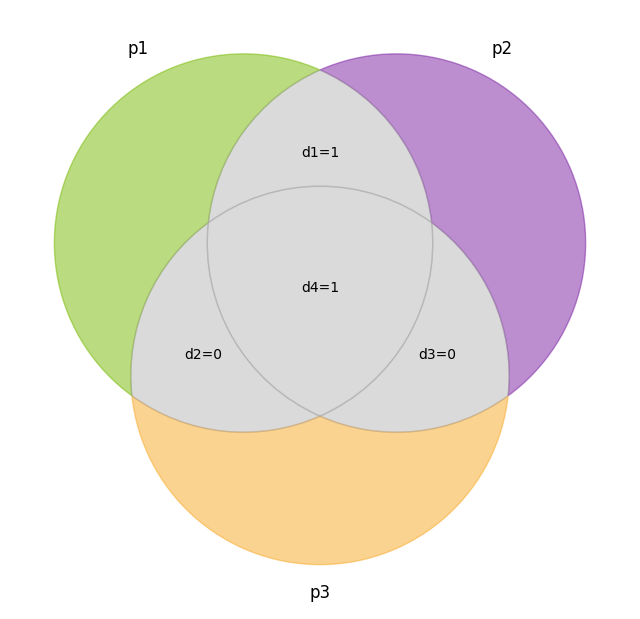

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from ipywidgets import VBox, HBox

# Function to calculate parity bits
def calculate_parity_bits(data_bits):
    d1, d2, d3, d4 = data_bits
    p1 = d1 ^ d2 ^ d4
    p2 = d1 ^ d3 ^ d4
    p3 = d2 ^ d3 ^ d4
    return [p1, p2, p3]

# Function to update the Venn diagram labels based on data bits
def update_venn_labels(data_bits):
    # Clear the previous output
    clear_output(wait=True)

    # Clear the computed parity bit outputs
    output_p1.clear_output()
    output_p2.clear_output()
    output_p3.clear_output()

    # Display the widgets again
    display(VBox([title, data_bits_widget, HBox([button_p1, button_p2, button_p3], layout=widgets.Layout(justify_content='space-between')), HBox([output_p1, output_p2, output_p3])]))

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('p1', 'p2', 'p3'))

    # Set colors for the circles using NVIDIA color palette
    venn.get_patch_by_id('100').set_color('#76B900')  # Green
    venn.get_patch_by_id('010').set_color('#7A1FA2')  # Purple
    venn.get_patch_by_id('001').set_color('#F9A825')  # Yellow

    # Set colors for the intersections
    venn.get_patch_by_id('110').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('101').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('011').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('111').set_color('#A3A3A3')  # Light Gray

    # Set transparency for the circles
    venn.get_patch_by_id('100').set_alpha(0.5)
    venn.get_patch_by_id('010').set_alpha(0.5)
    venn.get_patch_by_id('001').set_alpha(0.5)

    # Label the intersections with data bits
    venn.get_label_by_id('100').set_text(f'')
    venn.get_label_by_id('010').set_text(f'')
    venn.get_label_by_id('001').set_text(f'')
    venn.get_label_by_id('110').set_text(f'd1={data_bits[0]}')
    venn.get_label_by_id('101').set_text(f'd2={data_bits[1]}')
    venn.get_label_by_id('011').set_text(f'd3={data_bits[2]}')
    venn.get_label_by_id('111').set_text(f'd4={data_bits[3]}')

    plt.show()

# Function to update the Venn diagram and display the messages
def update_venn(data_bits, parity_bit):
    parity_bits = calculate_parity_bits(data_bits)

    # Clear the previous output
    clear_output(wait=True)

    # Display the widgets again
    display(VBox([title, data_bits_widget, HBox([button_p1, button_p2, button_p3], layout=widgets.Layout(justify_content='space-between')), HBox([output_p1, output_p2, output_p3])]))

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('p1', 'p2', 'p3'))

    # Set colors for the circles using NVIDIA color palette
    venn.get_patch_by_id('100').set_color('#76B900')  # Green
    venn.get_patch_by_id('010').set_color('#7A1FA2')  # Purple
    venn.get_patch_by_id('001').set_color('#F9A825')  # Yellow

    # Set colors for the intersections
    venn.get_patch_by_id('110').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('101').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('011').set_color('#A3A3A3')  # Light Gray
    venn.get_patch_by_id('111').set_color('#A3A3A3')  # Light Gray


    # Set transparency for the circles
    venn.get_patch_by_id('100').set_alpha(0.5)
    venn.get_patch_by_id('010').set_alpha(0.5)
    venn.get_patch_by_id('001').set_alpha(0.5)

    # Label the intersections with data bits
    venn.get_label_by_id('100').set_text(f'')
    venn.get_label_by_id('010').set_text(f'')
    venn.get_label_by_id('001').set_text(f'')
    venn.get_label_by_id('110').set_text(f'd1={data_bits[0]}')
    venn.get_label_by_id('101').set_text(f'd2={data_bits[1]}')
    venn.get_label_by_id('011').set_text(f'd3={data_bits[2]}')
    venn.get_label_by_id('111').set_text(f'd4={data_bits[3]}')

    # Highlight the selected parity bit and relevant data bits
    if parity_bit == 'p1':
        venn.get_patch_by_id('100').set_edgecolor('black')
        venn.get_patch_by_id('100').set_linewidth(5)
        venn.get_patch_by_id('110').set_color('#76B900')  # Green
        venn.get_patch_by_id('101').set_color('#76B900')  # Green
        venn.get_patch_by_id('111').set_color('#76B900')  # Green
        venn.get_patch_by_id('110').set_edgecolor('black')
        venn.get_patch_by_id('110').set_linewidth(5)
        venn.get_patch_by_id('101').set_edgecolor('black')
        venn.get_patch_by_id('101').set_linewidth(5)
        venn.get_patch_by_id('111').set_edgecolor('black')
        venn.get_patch_by_id('111').set_linewidth(5)
        output_p1.clear_output()
        with output_p1:
            display(HTML(f"<b>p1 = d1 + d2 + d4 (mod 2)=</b> {data_bits[0]} + {data_bits[1]} + {data_bits[3]} (mod 2) = {parity_bits[0]}"))
    elif parity_bit == 'p2':
        venn.get_patch_by_id('010').set_edgecolor('black')
        venn.get_patch_by_id('010').set_linewidth(5)
        venn.get_patch_by_id('110').set_color('#7A1FA2')  # Purple
        venn.get_patch_by_id('011').set_color('#7A1FA2')  # Purple
        venn.get_patch_by_id('111').set_color('#7A1FA2')  # Purple
        venn.get_patch_by_id('110').set_edgecolor('black')
        venn.get_patch_by_id('110').set_linewidth(5)
        venn.get_patch_by_id('011').set_edgecolor('black')
        venn.get_patch_by_id('011').set_linewidth(5)
        venn.get_patch_by_id('111').set_edgecolor('black')
        venn.get_patch_by_id('111').set_linewidth(5)
        output_p2.clear_output()
        with output_p2:
            display(HTML(f"<b>p2 = d1 + d3 + d4 (mod 2)=</b> {data_bits[0]} + {data_bits[2]} + {data_bits[3]} (mod 2) = {parity_bits[1]}"))
    elif parity_bit == 'p3':
        venn.get_patch_by_id('001').set_edgecolor('black')
        venn.get_patch_by_id('001').set_linewidth(5)
        venn.get_patch_by_id('101').set_color('#F9A825')  # Yellow
        venn.get_patch_by_id('011').set_color('#F9A825')  # Yellow
        venn.get_patch_by_id('111').set_color('#F9A825')  # Yellow
        venn.get_patch_by_id('101').set_edgecolor('black')
        venn.get_patch_by_id('101').set_linewidth(5)
        venn.get_patch_by_id('011').set_edgecolor('black')
        venn.get_patch_by_id('011').set_linewidth(5)
        venn.get_patch_by_id('111').set_edgecolor('black')
        venn.get_patch_by_id('111').set_linewidth(5)
        output_p3.clear_output()
        with output_p3:
            display(HTML(f"<b>p3 = d2 + d3 + d4 (mod 2)=</b> {data_bits[1]} + {data_bits[2]} + {data_bits[3]} (mod 2) = {parity_bits[2]}"))

    plt.show()

# Create a title widget
title = widgets.Label(value="Hamming Code Visualization: Computing parity bits (p1, p2, p3)")


# Create widgets for user input
data_bits_widget = widgets.Dropdown(
    options=['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111'],
    value='1001',
    description='Data Bits (d1, d2, d3, d4):', style={'description_width': 'initial'}
)

# Create buttons for parity bits
button_p1 = widgets.Button(description='Compute p1', layout=widgets.Layout(width='150px'), style=widgets.ButtonStyle(button_color='#BBE07F'))  # Green
button_p2 = widgets.Button(description='Compute p2', layout=widgets.Layout(width='150px'), style=widgets.ButtonStyle(button_color='#BD8FD1'))  # Purple
button_p3 = widgets.Button(description='Compute p3', layout=widgets.Layout(width='150px'), style=widgets.ButtonStyle(button_color='#FCD492'))  # Yellow

# Create output areas for parity bit results
output_p1 = widgets.Output(layout=widgets.Layout(width='300px'))
output_p2 = widgets.Output(layout=widgets.Layout(width='300px'))
output_p3 = widgets.Output(layout=widgets.Layout(width='300px'))

# Define the button click events
def on_button_p1_click(b):
    data_bits_list = [int(bit) for bit in data_bits_widget.value]
    update_venn(data_bits_list, 'p1')

def on_button_p2_click(b):
    data_bits_list = [int(bit) for bit in data_bits_widget.value]
    update_venn(data_bits_list, 'p2')

def on_button_p3_click(b):
    data_bits_list = [int(bit) for bit in data_bits_widget.value]
    update_venn(data_bits_list, 'p3')

button_p1.on_click(on_button_p1_click)
button_p2.on_click(on_button_p2_click)
button_p3.on_click(on_button_p3_click)

# Define the dropdown change event
def on_data_bits_change(change):
    data_bits_list = [int(bit) for bit in change['new']]
    update_venn_labels(data_bits_list)

data_bits_widget.observe(on_data_bits_change, names='value')

# Display the widgets
display(VBox([title, data_bits_widget, HBox([button_p1, button_p2, button_p3], layout=widgets.Layout(justify_content='space-between')), HBox([output_p1, output_p2, output_p3])]))

# Initial update of the Venn diagram labels
update_venn_labels([int(bit) for bit in data_bits_widget.value])


The Hamming code takes advantage of the fact that the parity bits can encode up to $2^3 = 8$ syndromes, more than enough to consider the seven possible single bit flip errors that could occur. This means, 4 bits can be encoded with 7 bits which is an improvement over the $n$ to 1 encoding of the repetition code.

**Checkpoint:**  Suppose you sent the logical code word 0110110, but the recipient received the message 0110100.  We'll assume that at most only one error occurred.  Would the recipient be able to identify if there was an error?  If so, could they locate the error?  
Hint: errors could occur on any of the data or the parity bits.

In practice, a large message can be broken into blocks with each block is encoded using the Hamming code.  The code scales much better than the repetition code.  A Hamming code can be produced for any integer $r$ greater than 1, such that the code is characterized as $[2^r-1,2^r -r -1,3]$.  So for a message of size $2^5 -5 -1 = 26$, the Hamming code would require only $2^5-1 =31$ bits while a three bit repetition code would require $26*3 = 78$ bits.

### Exercise 1.2: Matrix form of the Hamming Code ###

The Hamming code is commonly constructed with special matrices so a few simple linear algebra operations can encode and decode messages. The next two cells will have you define this matrices and see if you can match the example above.  

First, define the generator matrix $G$ such that a dot product between the message and $G$  mod2 performs the valid encoding. Hint: G should be a 4x7 matrix. 

In [7]:
message = np.array([0, 1, 1, 0])

# The G matrix should properly encode the message when the following calculation is performed
G = np.array([
[1,1,0],
[1,0,1],
[0,1,1],
[1,1,1]
])

encoded = np.dot(message, G) % 2
print(encoded)

[1 1 0]


Now, define the parity check matrix $H$ such that $Hv \mod 2$ produces a syndrome, where $v$ is the received message vector. 

In [ ]:
received = np.array([0, 0, 1, 0,1,1,0])
print(received)

# Define the parity check matrix H which takes a message and determines the syndrome.
H = np.array([
#FILL IN H
])

decoded = np.dot(H, recieved) % 2

# Should print [0 1 1]
print(decoded)

## 1.4 What Makes QEC so Hard?

QEC shares the same goal as classical EC, but comes with a number of unique challenges thanks to the properties of quantum mechanics.  This section will list the primary differences, and the following section will explain how these challenges can be addressed.
 
1.  Continuous Errors - Classical errors are always discrete bit flips. Quantum errors are continuous and can manifest in an infinite number of ways, potentially shifting a qubit's state to any point on the Bloch sphere. For instance, the figure below illustrates many possible errors that affect a qubit starting in the $\ket{0}$ state. Errors can perturb states incoherently (from environmental effects) or coherently from slight hardware imperfections. This invites the question, "Does QEC require an infinite amount of resources to correct errors?"
   
<img src="Images/c_error.png" alt="Drawing" style="width: 300px;"/>

2. No Cloning - Quantum states cannot be copied. That is to say that the following expression holds:$~\nexists U \text{ such that } U(\ket{\psi} \otimes \ket{\rho}) =  \ket{\psi} \otimes\ket{\psi}$. This means we cannot just send multiple copies of the quantum state through the noisy channel like the classical repetition code. 

3. Destructive Measurement - In classical EC, the state can be accessed at any time, making decoding much easier. Measuring a quantum state collapses it, making the EC moot if the state is destroyed. Therefore, more clever ways to extract syndromes are required. A secondary consequence of this fact is sampling error.  Even if an algorithm could perform perfectly ensuring no sources of error, many applications require statistical sampling of the resulting state. If we sampled $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$ the frequency of 0's would be close to $\alpha^2$ but deviate based on the number of samples per the Central Limit Theorem.

4. Scalability - Though scalability is an issue for classical EC, it is far more severe for QEC. Today's noisy intermediate scale quantum devices are very difficult to control, so each additional qubit required for QEC comes at great cost.  Qubits also have short coherence times, so QEC procedures must complete within strict time constraints which gets harder at scale. Finally, the threshold theorem is in play. In classical EC, adding more bits always reduces the logical error rate. This is not true for quantum - physical qubits must have noise below a specific threshold in order for scaling the code to improve the error rates,  otherwise, the results just get worse.


## 1.5 There is still hope for QEC!

The challenges discussed above are daunting but there are many ingenious techniques developed to help circumvent them. That said, practical QEC remains difficult to realize and is an extremely active research field - viewed as one of the most important prerequisites for useful quantum computing.  This section will begin to bridge the gap between classical EC and QEC.


### Digitization of errors

Errors can perturb states incoherently from environmental effects or coherently from slight hardware imperfections.  While both types of errors can be addressed, we’ll focus on coherent errors first because they’re often easier to isolate and analyze.

For instance, a rotation gate that should be at an angle of $\frac{\pi}{16} \approx 0.196 $ ends up being more like 0.17. This may seem inconsequential, but imperfections like this accumulate and quickly ruin the outcome of a quantum algorithm.  Execute the code block below and use the slider to change the number of rotation gates executed to see how the error can become substantial.  Feel free to experiment with different values for the `angle`, `noisy_angle`, and the rotation axis in the `rotation_kernel`. 




In [8]:
# Angles of rotation of a qubit
angle = np.pi / 16 
noisy_angle = 0.17 

# Kernel to initialize a qubit in the zero ket state and rotate it about the x axis by given angle n times
@cudaq.kernel
def rotation_kernel(n: int, angle: float):
    qubit = cudaq.qubit()
    for _ in range(n):
        rx(angle, qubit) # CHANGE THE ROTATION AXIS

# Function to plot sample results
def plot_results(results1, results2):
    # Convert the sample results to a dictionary
    result_dictionary1 = {k: v for k, v in results1.items()}
    result_dictionary2 = {k: v for k, v in results2.items()}
    
    # Get all unique x-values from both dictionaries
    all_keys = set(result_dictionary1.keys()).union(set(result_dictionary2.keys()))
    all_keys = sorted(all_keys)

    # Convert the dictionary to lists for x and y values
    x1 = list(all_keys)
    y1 = list(result_dictionary1.values())
    y2 = list(result_dictionary2.values())

    # Create the combined histogram
    bar_width = 0.35
    x_indices = range(len(x1))

    plt.bar(x_indices, y1, width=bar_width, color='#76B900', label='Noise-Free Results')
    plt.bar([i + bar_width for i in x_indices], y2, width=bar_width, color='#484848', label='Noisy Results')

    # Add title and labels
    plt.title('Comparing sampling results of n applications of a noise-free gate with a noisy version')
    plt.xlabel("Basis States")
    plt.ylabel("Frequency")
    plt.xticks([i + bar_width / 2 for i in x_indices], x1)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Function to update the plot based on the slider value
def update_plot(num_rotations):
    expected_result = cudaq.sample(rotation_kernel, num_rotations, angle)
    noisy_result = cudaq.sample(rotation_kernel, num_rotations, noisy_angle)
    plot_results(expected_result, noisy_result)

# Create an interactive slider
slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description='n:', continuous_update=False)
interact(update_plot, num_rotations=slider)

interactive(children=(IntSlider(value=1, continuous_update=False, description='n:', max=20, min=1), Output()),…

<function __main__.update_plot(num_rotations)>

Among the various coherent errors that can occur on a qubit storing the quantum state $\ket{\psi} = \alpha \ket{0}+\beta\ket{1}$, we will focus on three specific types:
* **Bit flip errors** swap a qubit's amplitudes, transforming $\ket{\psi}$ to $\beta\ket{0}+\alpha\ket{1}$.
* **Phase flip errors** introduce a sign change in one of the amplitudes, transforming $\ket{\psi}$ to $\alpha\ket{0}-\beta\ket{1}$.
* **Combining a bit flip with a phase flip error** swaps amplitudes and applies a sign change, transforming $\ket{\psi}$ to $\beta\ket{0}-\alpha\ket{1}$.

Run the cell below to open an interactive tool that allows you to visualize the impact of different error types on various quantum states. Observe how some error types may not alter the state. Why do you think that happens? What patterns can you identify?

In [9]:
# Execute this cell to see the interactive widget
# Don't concern yourself with the code below this line
# Function to update and display the Bloch sphere
def update_bloch_sphere(theta, phi, error_type):
    alpha = np.cos(theta / 2)
    beta = np.sin(theta / 2) * np.exp(1j * phi)
    coefficients = [complex(alpha, 0), complex(0, beta)]
    error_types = ['Bit Flip', 'Phase Flip', 'Bit & Phase Flip']
    @cudaq.kernel
    def initial_state_kernel(coefficients: list[complex]):
        qubit = cudaq.qvector(coefficients)

    @cudaq.kernel
    def initial_state_error(coefficients: list[complex], error: int):
        qubit = cudaq.qvector(coefficients)
        if error == 0 or error == 2:
            # bit flip error
            x(qubit)
        if error == 1 or error == 2:
            # phase flip error
            z(qubit)

    state_no_error = cudaq.get_state(initial_state_kernel, coefficients)
    state_with_error = cudaq.get_state(initial_state_error, coefficients, error_type)

    blochSphereList = []
    # Define a sphere object representing the state of the single qubit
    sphere = cudaq.add_to_bloch_sphere(state_no_error)
    blochSphereList.append(sphere)
    sphere = cudaq.add_to_bloch_sphere(state_with_error)
    blochSphereList.append(sphere)

    # Create output widgets for the Bloch spheres and text
    out1 = Output()
    out2 = Output()
    text1 = Output()
    text2 = Output()

    with out1:
        cudaq.show([blochSphereList[0]], nrows=1, ncols=1)
    with out2:
        cudaq.show([blochSphereList[1]], nrows=1, ncols=1)
    with text1:
        print(f"|ψ> = cos(θ/2)|0⟩ + e^(iφ)sin(θ/2)|1⟩")
    with text2:
        print("|ψ⟩ with a ", error_types[error_type], " error")

    display(VBox([HBox([VBox([text1, out1]), VBox([text2, out2])])]))

# Create the interactive widget
theta_slider = widgets.FloatSlider(value=np.pi/2, min=0, max=2*np.pi, step=0.01, description='θ (radians):')
phi_slider = widgets.FloatSlider(value=0, min=0, max=np.pi, step=0.01, description='φ (radians):')
error_selector = widgets.Dropdown(options=[('None', -1), ('Bit Flip', 0), ('Phase Flip', 1), ('Bit & Phase Flip', 2)], value=-1, description='Error Type:')

interact(update_bloch_sphere, theta=theta_slider, phi=phi_slider, error_type=error_selector)


interactive(children=(FloatSlider(value=1.5707963267948966, description='θ (radians):', max=6.283185307179586,…

<function __main__.update_bloch_sphere(theta, phi, error_type)>

Once we have identified one of these errors, we can correct it. For instance, if a qubit has undergone a bit flip error, we can correct it by applying an $X$ gate. Similarly, to correct a qubit that has experienced a phase flip error, we simply apply a $Z$ gate. How would you correct a qubit that has been identified as having undergone a bit flip error followed by a phase flip error?  

We can address all coherent errors with a key insight: although the Bloch sphere suggests errors can occur through infinitely many possible rotations, all such errors can be broken down into three basic forms &mdash; bit flips, phase flips, or a combination of both bit flips and phase flips.  

If you'd like an explanation of why this decomposition works, consult the optional section below. For now, remember that by detecting and correcting these three core error types, we can effectively handle any coherent noise.  

> **Optional:** Consider a qubit in the following normalized state.
> $$ \ket{\psi}  =  \cos\frac{\theta}{2}\ket{0} + e^{i\phi}\sin\frac{\theta}{2}\ket{1} $$
> 
>  Coherent errors can be represented by the application of a Unitary $U(\delta\theta,\delta\phi)$ which acts on the ideal state and perturbs it.
>$$ U(\delta\theta,\delta\phi)\ket{\psi}  =  \cos\frac{\theta +\delta\theta}{2}\ket{0} + e^{i\phi+\delta\phi}\sin\frac{\theta+\delta\theta}{2}\ket{1} $$
> Using the fact that the Pauli matrices form a basis for any 2x2 unitary matrix and taking advantage of the identity $Y=iXZ$, the operation can be rewritten as
> $$ U(\delta\theta,\delta\phi) \ket{\psi} = \alpha_II\ket{\psi} +\alpha_X X\ket{\psi}+\alpha_Z Z\ket{\psi}+\alpha_{XZ}XZ\ket{\psi}   $$
> This means that any coherent error can be **digitized** into X-type bit flip errors ($X \ket{\psi} = \alpha X\ket{0} + \beta X\ket{1} = \alpha\ket{1} + \beta\ket{0}$), Z-type phase flip errors ($Z\ket{\psi} = \alpha Z\ket{0} + \beta Z\ket{1} = \alpha\ket{0} - \beta\ket{1}$), or a combination of the two (XZ). This makes correction much more tractable, as there are only three types of errors to consider.

### Syndrome Extraction

The no cloning principle means quantum states cannot be copied for QEC. We'll need a clever way to extract syndromes from the logical state that does not rely on repetition. But, how is this done without destroying the information that is being protected?

The solution involves **stabilizers** which are specially designed operators that act on a logical state without changing it, but still enable us to learn about errors by performing projective measurement of ancilla qubits.  The next notebook in this series will introduce stabilizers with more mathematical rigor, and the example in section 1.6 of this lab will provide a more concrete example of a simple stabilizer in action.

### Better QEC codes and AI solutions

Finally, overcoming the QEC scaling challenges will require breakthroughs on many fronts. Significant research efforts are targeting discovery of more efficient QEC codes that require fewer qubits.  AI is already showing great promise as a tool to help find new QEC codes, and accelerate decoding. Later notebooks will explore AI for QEC applications.


## 1.6 The Quantum Repetition Code

A quantum state cannot be cloned, but it can be redundantly encoded across additional entangled qubits. Let's start with a generic normalized qubit state $\ket{\psi}$:

$$\ket{\psi} = \alpha\ket{0} +\beta\ket{1}.$$ 

The 0 and 1 states can be encoded into a logical state making use of the larger 8-dimensional Hilbert space of three qubits:  

$$\ket{\psi}_L = \alpha\ket{000} +\beta\ket{111} = \alpha\ket{0}_L +\beta\ket{1}_L.$$ 

Note that this is *not* equivalent to $\ket{\psi} \otimes \ket{\psi} \otimes \ket{\psi}$.

Consider now the entire Hilbert space spanned by the eight basis states.  The basis states are separated into the logical codewords that make up the codespace:   

| Codespace    | Notation for the logical codewords| 
| ----------- | ----------- | 
| $\ket{000}$ | $\ket{0}_L$ |
|$\ket{111}$ | $\ket{1}_L$ |

and the remaining basis states make up the error space:

| Error space | 
| ----------- | 
| $\ket{001}$ | 
| $\ket{010}$ |
| $\ket{100}$ |
| $\ket{011}$ |
| $\ket{101}$ |
| $\ket{110}$ |

Assume that the state $\ket{111}$ is transmitted through a noisy channel and becomes $\ket{011}$?  How might it be decoded to tell which logical codeword it is closest to?  Remember, you cannot simply examine the state and perform a majority count as no information about the state is accessible without some sort of measurement that induces wavefunction collapse.  

Consider the operators $Z_1Z_2$ and $Z_2Z_3$.  (Remember that $Z_n$ returns an eigenvalue of +1 if the nth qubit in a ket is a 0 and -1 if it is a 1).  
It turns out that these operators have special properties such that the eigenvalues produced when they act on any of the states in the codespace or error space can be extracted with ancilla qubits without disturbing the state.  This means, there is a way to extract parity check information just like the classical Hamming code!

Note: Operators with these "special properties" are called stabilizers and will be rigorously introduced in the next lab.

The details of this extraction process are described shortly, but the implication is that syndromes can be produced from the parity check results and used to identify corrections to the quantum repetition code without destroying the encoded state. Considering only single bit flip errors, the table below shows the possible syndromes, the corresponding errors, and the operation that can be applied to correct the error assuming $\ket{111}$ is the transmitted message.  

| $Z_1Z_2$ Syndrome   | $Z_2Z_3$ Syndrome| Encoded State | Single Bit Flip Correction 
| ----------- | ----------- | ----------- | ----------- | 
| 0 | 0 | $\ket{111}$ | none |
| 1 | 0 | $\ket{011}$ | $X_1$ |
| 0 | 1 | $\ket{110}$ | $X_3$ |
| 1 | 1 | $\ket{101}$ | $X_2$ |


Like the classical repetition code, there is no way to know for certain if a 10 syndrome corresponds to a single bit flip error from the $\ket{111}$ codeword or a two bit flip error from the $\ket{000}$ codeword.  However, it is always prudent to assume that the case with fewer errors is more likely.

The entire quantum circuit for the three qubit repetition code is shown below, where the ancilla qubits are used to compute the $Z_1Z_2$ and $Z_2Z_3$ syndromes.



<img src="Images/repcircuit.png" alt="Drawing" style="width: 800px;"/>



It is helpful to explore in greater detail how the syndromes can be extracted using the ancilla qubits without disturbing the state.
First, consider the initial state of the first ancilla after application of a Hadamard gate and the encoded state after a bit flip has occurred on the first data qubit.

$$ \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})\ket{011} $$

Next, a controlled $Z_1Z_2$ operation is applied to the data qubits resulting in

$$ \frac{1}{\sqrt{2}}(\ket{0}\ket{011} + \ket{1}Z_1Z_2\ket{011}), $$

followed by an application of the second Hadamard:

$$ \frac{1}{2} ((\ket{0}+\ket{1})\ket{011} + (\ket{0} -\ket{1})Z_1Z_2\ket{011})  =  \ket{0}(\frac{1+Z_1Z_2}{2})\ket{011} + \ket{1}(\frac{1-Z_1Z_2}{2})\ket{011}  .   $$

Now, if $Z_1Z_2\ket{011}$ is evaluated, the result is $-\ket{011}$ and the entire state simplifies to $\ket{1}\ket{011}$ meaning upon measurement, the first ancilla qubit will be measured as 1 with certainty and the data qubits remain undisturbed in the $\ket{011}$ state:


$$ \ket{0}(\frac{1+Z_1Z_2}{2})\ket{011} + \ket{1}(\frac{1-Z_1Z_2}{2})\ket{011}  =   \ket{0}(\frac{1+ -1}{2})\ket{011} + \ket{1}(\frac{1--1}{2})\ket{011}  =   \ket{1}\ket{011}.  $$

A similar analysis will show that the second ancilla qubit will be measured as 0 with certainty without distubring the data qubits.  Accordoing to the syndrome table, 
this will trigger an application of the $X$ gate on the first qubit to correct the error.


## 1.7 Exercise 1.3: Coding the Quantum Repetition Code

Now that you understand the quantum repetition code, try to code it using CUDA-Q.  Fill in each of the steps below marked "#TODO". CUDA-Q contains a couple of features particularly helpful for building QEC workflows.  First, and already completed for you, is the definition of a custom noise model which produces custom identity operations that can randomly perform bit flips on specific qubits. Second, you can measure the ancilla qubits within the kernel and use the result to perform a correction operation.  The documentation example on [building kernels](https://nvidia.github.io/cuda-quantum/latest/using/examples/building_kernels.html) and [mid-circuit measurement](https://nvidia.github.io/cuda-quantum/latest/examples/python/measuring_kernels.html) may be helpful for this exercise.

Try to code all the steps and then sample the kernel to determine the logical error rate.

In [14]:
import cudaq
import numpy as np

#First, create an empty noise model
noise_model = cudaq.NoiseModel()
p = 0.1

#Build a custom gate which applies the identity operation
cudaq.register_operation("custom_i", np.array([1, 0, 0, 1]))

#Add a bitflip noise channel to the custom_i gate applied to each qubit
noise_model.add_channel("custom_i", [0], cudaq.BitFlipChannel(p))
noise_model.add_channel("custom_i", [1], cudaq.BitFlipChannel(p))
noise_model.add_channel("custom_i", [2], cudaq.BitFlipChannel(p))

@cudaq.kernel
def three_qubit_repetition_code():
    """Prepares a kernel for the 3-bit quantum repetition code

    Returns
    -------
    cudaq.kernel
        Kernel for running the 3-bit quantum repetition code
          
    """  

    # Create register for data and ancilla qubits
    qvector = cudaq.qvector(5)


    # Initialize the logical |1> state as |111>
    x(qvector[0])
    x.ctrl(qvector[0], qvector[1])
    x.ctrl(qvector[0], qvector[2])

    # Apply custom_i to induce random bitflip errors
    custom_i(qvector[0])
    custom_i(qvector[1])
    custom_i(qvector[2])

    # Extract Syndromes
    h(qvector[3])
    h(qvector[4])
    x.ctrl(qvector[0], qvector[3])
    x.ctrl(qvector[1], qvector[3])
    x.ctrl(qvector[1], qvector[4])
    x.ctrl(qvector[2], qvector[4])
    h(qvector[3])
    h(qvector[4])

    # Correct errors based on syndromes
    # mz(qvector[3])
    # mz(qvector[4])

# Run the kernel and observe results
# The percent of samples that are 000 corresponds to the logical error rate
result = cudaq.sample(three_qubit_repetition_code, noise_model=noise_model)
print(result)

[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[2025-09-18 10:54:10.039] [warning] [CircuitSimulator.h:844] Applying noise is not supported on qpp simulator.
[

## Conclusion

You now have a basic understanding of EC and QEC. The next lab will explore stabilizers in more detail and equip you to code two of the most famous and fundamental QEC codes: the Shor code and the Steane code.